In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
import cv2
from PIL import Image
import cv2
import pytesseract
from pytesseract import image_to_string
import imutils
import skimage
from matplotlib import cm


In [2]:
def scan(path,side,debug):
        # load the image and compute the ratio of the old height
        # to the new height, clone it, and resize it
        image = cv2.imread(path)
        ratio = image.shape[0] / 500.0
        orig = image.copy()
        image = imutils.resize(image, height = 500)

        # convert the image to grayscale, blur it, and find edges
        # in the image
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         gray = cv2.medianBlur(gray, 5)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        
#         medianBlur(src, dst, ksize)
        #edged = cv2.Canny(gray, 75, 200)
        edged = cv2.Canny(gray, 150, 200)


        # find the contours in the edged image, keeping only the
        # largest ones, and initialize the screen contour
        cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
        j=0
        # loop over the contours
        for c in cnts:
                j=j+1
                # approximate the contour
                peri = cv2.arcLength(c, True)
                approx = cv2.approxPolyDP(c, 0.02 * peri, True)

                # if our approximated contour has four points, then we
                # can assume that we have found our screen
                if len(approx) == 4:
                    screenCnt = approx
                    warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
                    newimg = cv2.resize(warped,(1000,630))


                    if(side=="front"):
                        cv2.imwrite("temp_front.jpg",newimg)
              
                        try:
                            ADD_Rect(newimg,'front')
                            print("------------------------ Step 3 : Matching By a Template Front------------------------")
                            front_read("temp_front.jpg",debug)
                            break
                        except:
                            print("Try Another Contour")
                    elif(side=="back"):
                        cv2.imwrite("temp_back.jpg",newimg)
                        try:                  
                            ADD_Rect(newimg,'back')
                            print("------------------------ Step 3 : Matching By a Template Back------------------------")
                            back_read("temp_back.jpg",debug)
                            break
                        except:
                            print("Try Another Contour")
#                         break

def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")

	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]

	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]

	# return the ordered coordinates
	return rect
def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect

	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))

	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))

	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")

	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

	# return the warped image
	return warped


In [3]:
def front_read(front_src,debug):
    global pic
    global name
    global add
    global IDNumber
    global BDate
    global govern
    global ID,gender
    pic =np.zeros((320,265))
    name,add,IDNumber,BDate,gender = '','','','',''
    job,job2,gender,religion,a3zb,husband,govern = '','','','','','',''
    ID=''
    im_gray = cv2.imread(front_src, cv2.IMREAD_GRAYSCALE)
    im_gray=cv2.resize(im_gray, (1000,630))
    im_bw = im_gray
    kernel = np.ones((1, 1), np.uint8)
    thresh = 95
    im_bw = cv2.threshold(im_bw, thresh, 255, cv2.THRESH_BINARY)[1]
    # split the img
    pic = im_gray[20:350,10:275]
    Name = im_bw[150:310, 350:1000]
    address = im_bw[300:450, 350:1000]
    im_bw = im_bw.astype('uint8')

    ID = im_bw[500:560,400:1000]
    if debug==True:
        print('Name')
        plt.imshow(Name)
        plt.show()
        print('address')
        plt.imshow(address)
        plt.show()
        print('IDNumber')
        plt.imshow(ID)
        plt.show()

    # Reading the splitted images
    pytesseract.pytesseract.tesseract_cmd =r"C:\Users\ElDessoukyA\AppData\Local\Tesseract-OCR\tesseract.exe"
    TESSDATA_PREFIX = r'C:\Users\ElDessoukyA\AppData\Local\Tesseract-OCR'
    name=image_to_string(Name,lang="ara",config='--oem 1')  
    add=image_to_string(address,lang="ara+ara_number_id",config='--oem 1')#,config='--psm 7 -c tessedit_char_blacklist=0123456789.%')
    IDNumber=image_to_string(ID,lang="ara_number_id",config='--oem 1')
    IDNumber= ''.join(IDNumber.split())
   
    #Calculate the birth date
    if IDNumber[0]=='٢': 
        year = '١٩' + IDNumber[1:3]
    else:
        year = '٢٠' + IDNumber[1:3]
    month = IDNumber[3:5]
    day = IDNumber[5:7]
    BDate = year + '/' + month + '/'+ day
    #Getting the governorate.
    govern = placeOfBirth(IDNumber)
    gender = gen(IDNumber)

    global pic_ref
    global name_ref
    global add_ref
    global IDNumber_ref
    global BDate_ref
    global govern_ref
    global ID_ref
    global gender_ref
    
    pic_ref=pic
    name_ref=name
    add_ref=add
    IDNumber_ref=IDNumber
    BDate_ref=BDate
    govern_ref=govern
    ID_ref=ID
    gender_ref=gender

In [4]:

def back_read(source_image,debug):
    global job,job2,gender,religion,a3zb,husband
    source_image="temp_back.jpg"
    # source_image="Bck.PNG"
    img=Image.open(source_image) #1005 630
    im_gray = cv2.imread(source_image, cv2.IMREAD_GRAYSCALE)
    im_gray=cv2.resize(im_gray, (1000,630))
    ret,thresh_img = cv2.threshold(im_gray,127,255,cv2.THRESH_BINARY)
    kernel = np.ones((2,2),np.uint8)
    cv2.imwrite('threshold.jpg',thresh_img)
    img_binary=Image.open('threshold.jpg')
    pytesseract.pytesseract.tesseract_cmd =r"C:\Users\ElDessoukyA\AppData\Local\Tesseract-OCR\tesseract.exe"
    TESSDATA_PREFIX = r'C:\Users\ElDessoukyA\AppData\Local\Tesseract-OCR'
    text_all=image_to_string(img_binary,lang='ara',config="--psm 11 --oem 1")
    job = crop(230,70,820,140,'job',img_binary,text_all,debug)
    # job2 represents the place of work
    job2 = crop(230,125,820,190,'job2',img_binary,text_all,debug)
    #gender = crop(700,180,820,260,'gender',img_binary,text_all)
    gender = gen(IDNumber)
    religion = crop(480,180,760,260,'religion',img_binary,text_all,debug)

    a3zb = crop(200,180,570,260,'a3zb',img_binary,text_all,debug)
    # husband name in case of women
    # husband = crop(200,225,820,290,'husband',img_binary,text_all)
    husband = crop(200,225,820,280,'husband',img_binary,text_all,debug)
    ID_ref[0]
    global job_ref
    global job2_ref
    global religion_ref
    global a3zb_ref
    global husband_ref

    job_ref=job
    job2_ref=job2
    religion_ref=religion
    a3zb_ref=a3zb
    husband_ref=husband


In [5]:
def placeOfBirth(IDNumber):
    cairo="القاهرة"
    alex="الإسكندرية"
    ps="بورسعيد"
    sw="السويس"
    Du="دمياط"
    dac="الدقهلية"
    sha="الشرقية"
    qal="القليوبية"
    ksh="كفر الشيخ"
    ghar="الغربية"
    mno="المنوفية"
    bhe="البحيرة"
    isma="الإسماعيلية"
    giza="الجيزة"
    basw="بني سويف"
    fay="الفيوم"
    men="المنيا"
    asu="أسيوط"
    soha="سوهاج"
    qen="قنا"
    asw="أسوان"
    auxo="الأقصر"
    ba="البحر الأحمر"
    wg="الوادي الجديد"
    matr="مطروح"
    shsai="شمال سيناء"
    gasai="جنوب سيناء"
    out="خارج الجمهورية"
    govID= IDNumber[7:9]

    if(govID=="01")or (govID=="٠١"):
        gov=cairo
    elif(govID=="02")or (govID=="٠٢"):
        gov=alex
    elif(govID=="03")or (govID=="٠۳"):
        gov=ps
    elif(govID=="04")or (govID=="٠٤"):
        gov=sw
    elif(govID=="11")or (govID=="١١"):
        gov=Du
    elif(govID=="12")or (govID=="١٢"):
        gov=dac
    elif(govID=="13")or (govID=="۱۳"):
        gov=sha
    elif(govID=="14")or (govID=="١٤"):
        gov=qal
    elif(govID=="15")or (govID=="١٥"):
        gov=ksh
    elif(govID=="16")or (govID=="١٦"):
        gov=ghar
    elif(govID=="17")or (govID=="١۷"):
        gov=mno
    elif(govID=="18")or (govID=="١٨"):
        gov=bhe
    elif(govID=="19")or (govID=="١٩"):
        gov=isma
    elif(govID=="21")or (govID=="٢١"):
        gov=giza
    elif(govID=="22")or (govID=="٢٢"):
        gov=basw
    elif(govID=="23")or (govID=="٢۳"):
        gov=fay
    elif(govID=="24")or (govID=="٢٤"):
        gov=men
    elif(govID=="25")or (govID=="٢٥"):
        gov=asu
    elif(govID=="26")or (govID=="٢٦"):
        gov=soha
    elif(govID=="27")or (govID=="۲۷"):
        gov=qen
    elif(govID=="28")or (govID=="٢٨"):
        gov=asw
    elif(govID=="29")or (govID=="٢٩"):
        gov=auxo
    elif(govID=="31")or (govID=="۳۱"):
        gov=ba
    elif(govID=="32")or (govID=="۳۲"):
        gov=wg
    elif(govID=="33")or (govID=="۳۳"):
        gov=matr
    elif(govID=="34")or (govID=="۳٤"):
        gov=shsai
    elif(govID=="35")or (govID=="۳٥"):
        gov=gasai
    else:
        gov=out
    return gov

def gen(id):
    genderID = id[12:13]
    if(int(genderID)%2 == 0):
        gender="أنثى"
    else:
        gender="ذكر"
#     print(id,genderID,gender)

    return gender

def crop(dim1,dim2,dim3,dim4,name,img_binary,text_all,debug):
	area=(dim1,dim2,dim3,dim4)
	cropped_img=img_binary.crop(area)
	pytesseract.pytesseract.tesseract_cmd =r"C:\Users\ElDessoukyA\AppData\Local\Tesseract-OCR\tesseract.exe"
	TESSDATA_PREFIX = r'C:\Users\ElDessoukyA\AppData\Local\Tesseract-OCR'
	text=image_to_string(cropped_img,lang='ara',config="--oem 1")
	if debug==True:
		print(name)
		plt.imshow(cropped_img)
		plt.show()

# 	print(name , text)
# ##	cropped_img.show()
	if name=='religion':
		text=image_to_string(cropped_img,lang='ara',config="--psm 8 --oem 1")
		if ('مسلم' in text_all) or ('مسلم' in text):
			text='مسلم'
		elif ('مسيحي' in text_all) or ('مسيحي' in text):
			text='مسيحي'
		elif ('مسيحى' in text_all) or ('مسيحى' in text):
			text='مسيحي'
		elif ('مسلمة' in text_all) or ('مسلمة' in text):
			text='مسلمة'
		elif ('مسيحية' in text_all) or ('مسيحية' in text):
			text='مسيحية'
		else:
			text=''
	if name=='gender':
		text=image_to_string(cropped_img,lang='ara',config="--psm 8 --oem 1")
		if ('ذكر' in text_all) or ('ذكر' in text):
			text='ذكر'
			gender_ref=text
		elif ('أنثى' in text_all) or ('أنثى' in text):
			text='أنثى'
			gender_ref=text
		elif ('انثى' in text_all) or ('انثى' in text):
			text='أنثى'
			gender_ref=text            
		else:
			text=''

	if name=='a3zb':
		text=image_to_string(cropped_img,lang='ara',config="--psm 8 --oem 1")
		if ('أنسة' in text_all) or ('أنسة' in text):
			text='أنسة'
		elif ('متزوجة' in text_all) or ('متزوجة' in text):
			text='متزوجة'
		elif ('متزوج' in text_all) or ('متزوج' in text):
			text='متزوج'
		elif ('أعزب' in text_all) or ('أعزب' in text):
			text='أعزب'
		else:
			text=''
# 	print(name , text,"_______________",text_all)
	return text
def remove_newline2(txt):
    txt_arr=txt.splitlines()
    res=""
    for i in txt_arr:
        if(i!=""):
            res=res+" "+i+""
    return res[1:]


In [6]:
def ADD_Rect(img,side):

    color=(255,255, 0)
    thickness=2
    if side=='front':
        pic_start_point = (10, 20)
        pic_end_point = (275, 370)
        
        img=cv2.rectangle(img, pic_start_point, pic_end_point, color, thickness)
        
        Name_start_point=(350,150)
        Name_end_point=(1000,310)

        img=cv2.rectangle(img, Name_start_point, Name_end_point, color, thickness)

        address_start_point=(350,300)
        address_end_point=(1000,450)
        img=cv2.rectangle(img, address_start_point, address_end_point, color, thickness)
        
        ID_start_point=(400,500)
        ID_end_point=(1000,560)
        img=cv2.rectangle(img, ID_start_point, ID_end_point, color, thickness)
        
        start_point=(400,0)
        end_point=(900,150)
        img=cv2.rectangle(img, start_point, end_point, color, thickness)

        start_point=(50,580)
        end_point=(350,650)
        img=cv2.rectangle(img, start_point, end_point, color, thickness)

        start_point=(50,480)
        end_point=(350,550)
        img=cv2.rectangle(img, start_point, end_point, color, thickness)
        print("------------------------ Step 2 : Object Detected Front ----------------------------------")
        
    if side=='back':
        if husband !="":
            Husband_start_point = (200, 225)
            Husband_end_point = (820, 280)
            img=cv2.rectangle(img, Husband_start_point, Husband_end_point, color, thickness)
        
        a3zb_start_point=(200,180)
        a3zb_end_point=(505,260)
        img=cv2.rectangle(img, a3zb_start_point, a3zb_end_point, color, thickness)

        
        Job_start_point=(250,70)
        Job_end_point=(850,190)
        img=cv2.rectangle(img, Job_start_point, Job_end_point, color, thickness)
        
        religion_start_point=(515,180)
        religion_end_point=(740,260)
        img=cv2.rectangle(img, religion_start_point, religion_end_point, color, thickness)
        
        start_point=(200,40)
        end_point=(820,90)
        img=cv2.rectangle(img, start_point, end_point, color, thickness)
        
        start_point=(200,290)
        end_point=(820,350)
        img=cv2.rectangle(img, start_point, end_point, color, thickness)
        
        start_point=(760,180)
        end_point=(860,260)
        img=cv2.rectangle(img, start_point, end_point, color, thickness)
        print("------------------------ Step 2 : Object Detected Back ----------------------------------")

    plt.imshow(img)
    plt.show()      
    return img

In [7]:
def Print_Results():
    print("------------------------ Step 4 : OCR ENGINE Output ------------------------")
    print ("Name : " , remove_newline2(name_ref))
    print ("Address :", remove_newline2(add_ref))
    print ("IDNumber :", IDNumber_ref)
    print ("Date oF Birth :", BDate_ref)
    print ("Place oF Birth :", govern_ref)
    print ("Proffession :",remove_newline2(job_ref+job2_ref))
    print ("gender :" ,gender_ref)
#     if len(religion_ref) >1:
    print ("religion :" ,religion_ref)
#     if len(a3zb_ref) >1:
    print ("Marital Status :",a3zb_ref)
    if len(husband_ref) >3:
        print ("Husband Name :",husband_ref)
    plt.imshow(pic_ref,'gray')
    plt.show()

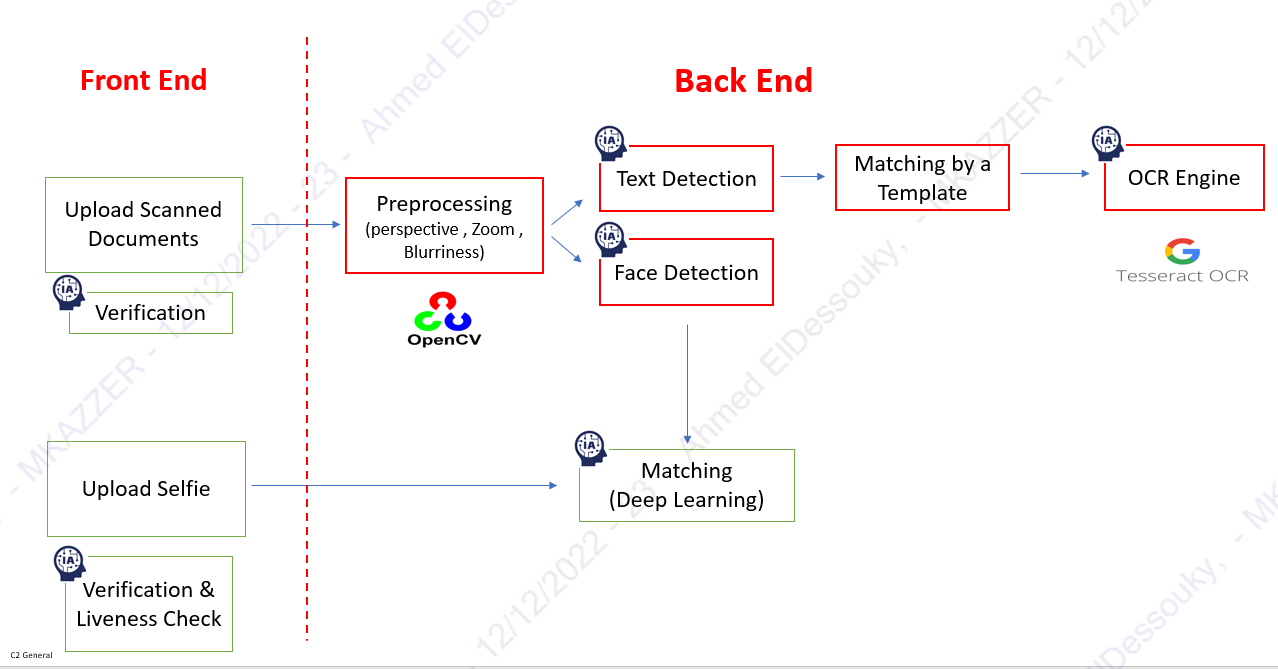

------------------------ Step 1 : Uploaded IMAGES ------------------------


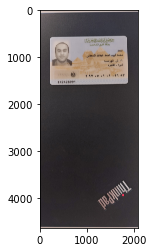

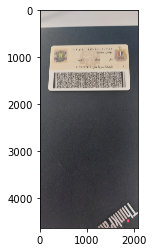

------------------------ Step 2 : Object Detected Front ----------------------------------


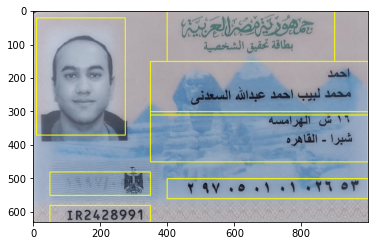

------------------------ Step 3 : Matching By a Template Front------------------------
Name


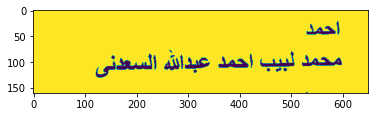

address


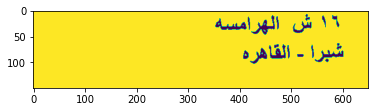

IDNumber


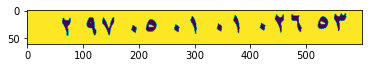

------------------------ Step 2 : Object Detected Back ----------------------------------


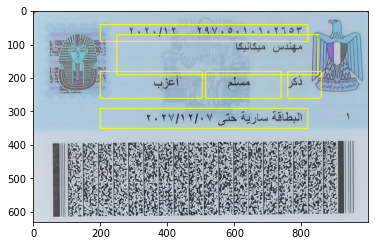

------------------------ Step 3 : Matching By a Template Back------------------------
job


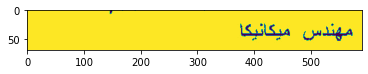

job2


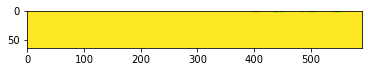

religion


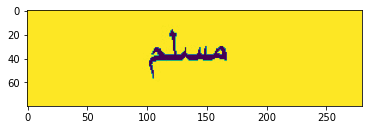

a3zb


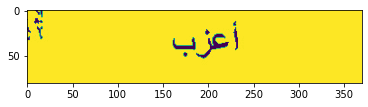

husband


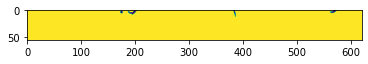

------------------------ Step 4 : OCR ENGINE Output ------------------------
Name :  أحمد محمد لبيب احمد عبدالله السعدنى
Address : 5 ش الهرامسه شبرا - القاهره
IDNumber : ٢٩٧٠٥٠١٠١٠٢٦٥٣
Date oF Birth : ١٩٩٧/٠٥/٠١
Place oF Birth : القاهرة
Proffession : مهندس ميكانيكا
gender : ذكر
religion : مسلم
Marital Status : أعزب


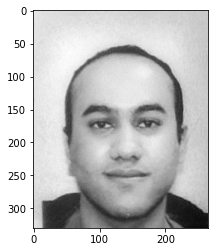

------------------------ Step 1 : Uploaded IMAGES ------------------------


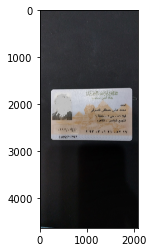

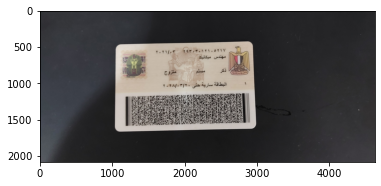

------------------------ Step 2 : Object Detected Front ----------------------------------


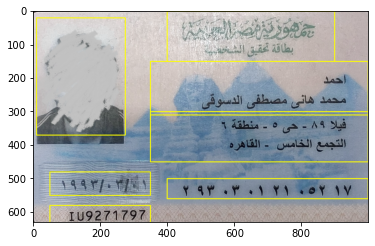

------------------------ Step 3 : Matching By a Template Front------------------------
Name


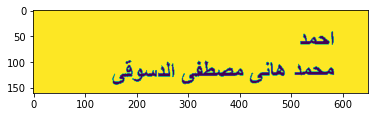

address


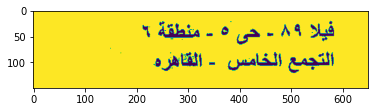

IDNumber


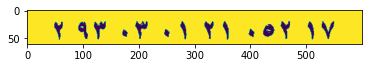

------------------------ Step 2 : Object Detected Back ----------------------------------


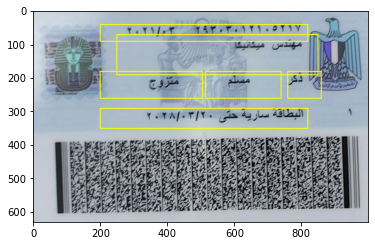

------------------------ Step 3 : Matching By a Template Back------------------------
job


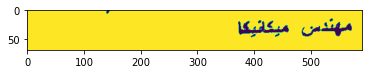

job2


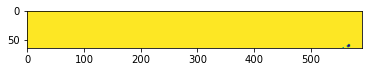

religion


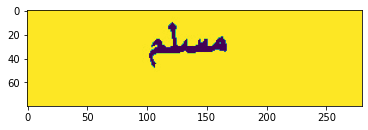

a3zb


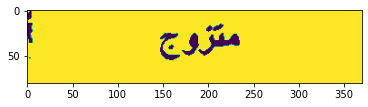

husband


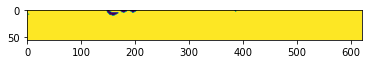

------------------------ Step 4 : OCR ENGINE Output ------------------------
Name :  احمد محمد هانى مصطفى الدسوقى
Address : فيلا 84 - حى ه - منطقة > التجمع الخامس - القثاهره
IDNumber : ٢٩٣٠٣٠١٢١٠٥٢١٧
Date oF Birth : ١٩٩٣/٠٣/٠١
Place oF Birth : الجيزة
Proffession : مهندس ميكئيكا
gender : ذكر
religion : مسلم
Marital Status : متزوج


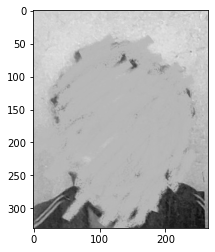

------------------------ Step 1 : Uploaded IMAGES ------------------------


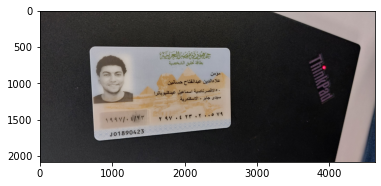

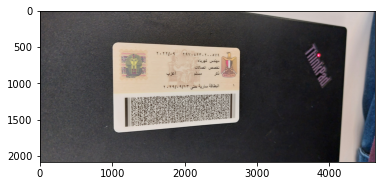

------------------------ Step 2 : Object Detected Front ----------------------------------


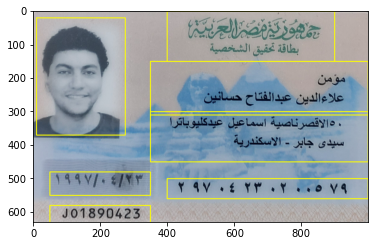

------------------------ Step 3 : Matching By a Template Front------------------------
Name


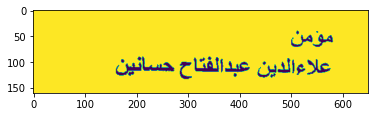

address


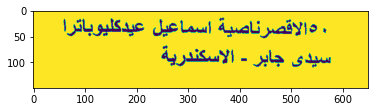

IDNumber


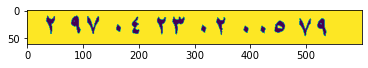

------------------------ Step 2 : Object Detected Back ----------------------------------


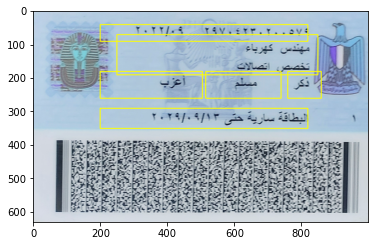

------------------------ Step 3 : Matching By a Template Back------------------------
job


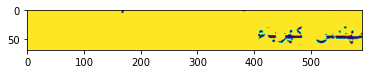

job2


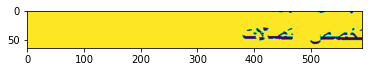

religion


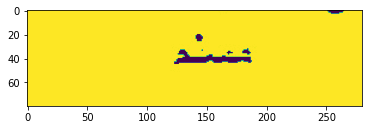

a3zb


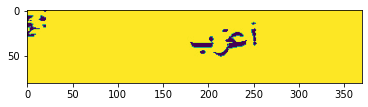

husband


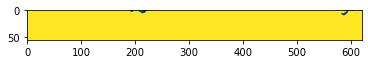

------------------------ Step 4 : OCR ENGINE Output ------------------------
Name :  مؤمن علاءالدين عبدالفتاح حسانين
Address : ‎٠‏ الاقصرناصية اسماعيل عيدكليوباترا سيدى جابر - الاسكندرية
IDNumber : ٢٩٧٠٤٢٣٠٢٠٠٥٧٩
Date oF Birth : ١٩٩٧/٠٤/٢٣
Place oF Birth : الإسكندرية
Proffession : 
gender : ذكر
religion : 
Marital Status : 


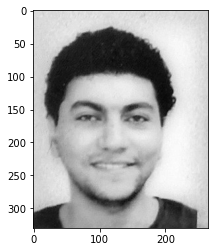

------------------------ Step 1 : Uploaded IMAGES ------------------------


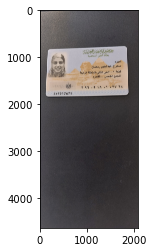

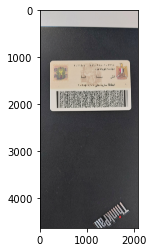

------------------------ Step 2 : Object Detected Front ----------------------------------


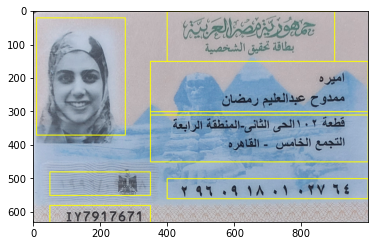

------------------------ Step 3 : Matching By a Template Front------------------------
Name


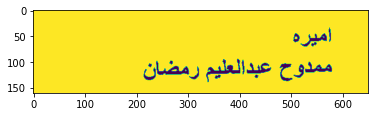

address


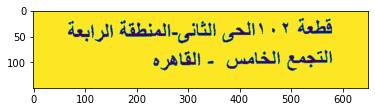

IDNumber


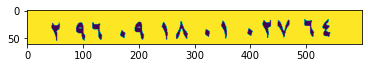

------------------------ Step 2 : Object Detected Back ----------------------------------


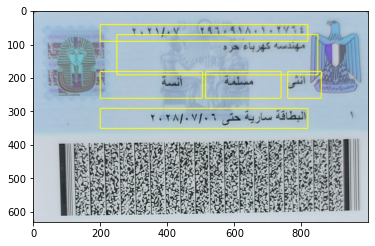

------------------------ Step 3 : Matching By a Template Back------------------------
job


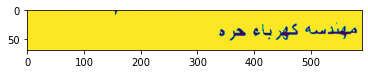

job2


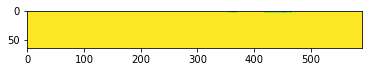

religion


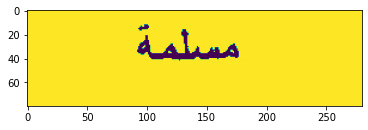

a3zb


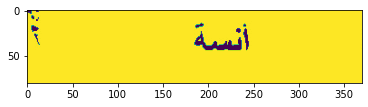

husband


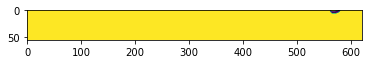

------------------------ Step 4 : OCR ENGINE Output ------------------------
Name :  أميره ممدوح عبدالعليم رمضان
Address : قطعة ؟١٠الحى‏ الثانى-المنطقة الرابعة التجمع الخامس - القاهره
IDNumber : ٢٩٦٠٩١٨٠١٠٢٧٦٤
Date oF Birth : ١٩٩٦/٠٩/١٨
Place oF Birth : القاهرة
Proffession : مهددسه كهرباء جره
gender : أنثى
religion : مسلم
Marital Status : أنسة


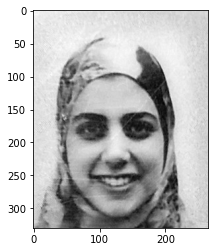

------------------------ Step 1 : Uploaded IMAGES ------------------------


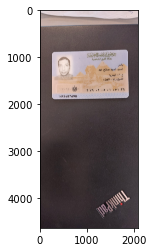

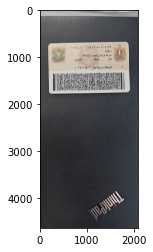

------------------------ Step 2 : Object Detected Front ----------------------------------


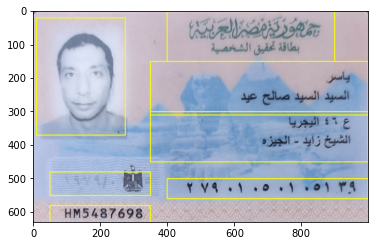

------------------------ Step 3 : Matching By a Template Front------------------------
Name


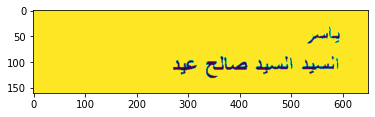

address


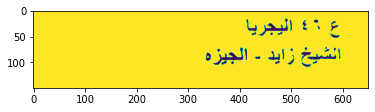

IDNumber


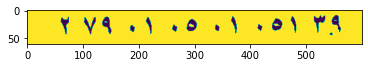

------------------------ Step 2 : Object Detected Back ----------------------------------


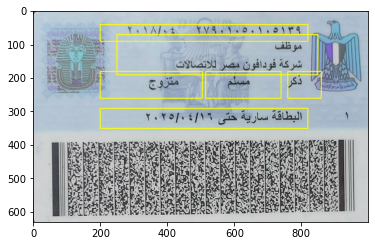

------------------------ Step 3 : Matching By a Template Back------------------------
job


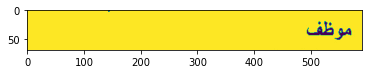

job2


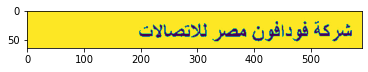

religion


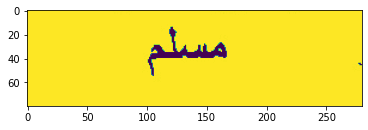

a3zb


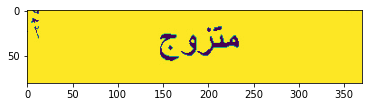

husband


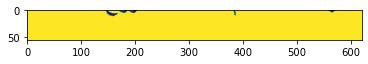

------------------------ Step 4 : OCR ENGINE Output ------------------------
Name :  ا صالح عيد السيد السيد
Address : ع 45 اليجريا الشييخ زايد - الجيزه
IDNumber : ٢٧٩٠١٠٥٠١٠٥١٣٩
Date oF Birth : ١٩٧٩/٠١/٠٥
Place oF Birth : القاهرة
Proffession : شركة فودافون مصر للاتصالات
gender : ذكر
religion : 
Marital Status : متزوج


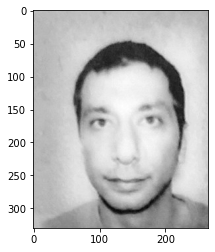

In [8]:
for i in range(5):
#     print(i+1)
    debug=True
    pic_ref,name_ref,add_ref,IDNumber_ref,BDate_ref,govern_ref,ID_ref,gender_ref='','','','','','','',''
    job_ref,job2_ref,religion_ref,a3zb_ref,husband_ref='','','','',''

    pic,name,add,IDNumber,BDate,govern,ID,gender='','','','','','','',''
    job,job2,religion,a3zb,husband='','','','',''

    front_path=r"D:\KYC\Training_Data\\"+ str(i) + "_front.jpg"
    back_path=r"D:\KYC\Training_Data\\"+ str(i) + "_back.jpg"
    
    print("------------------------ Step 1 : Uploaded IMAGES ------------------------")
    plt.imshow(cv2.imread(front_path)[:,:,::-1])
    plt.show()
    plt.imshow(cv2.imread(back_path)[:,:,::-1])
    plt.show()

    scan(front_path,"front",debug)
    scan(back_path,"back",debug)

    Print_Results()
